In [38]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from helpers import imshow

In [39]:
def whiteOut(frame):
    #remove white stuff, return a mask of the intsresting stuff
    
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # define range of white color in HSV
    # change it according to your need !
    sensitivity = 14
    #lower_white = np.array([0,0,255-sensitivity])
    #upper_white = np.array([255,sensitivity,255])
    
    lower_white = np.array([0, 0, 255-sensitivity])
    upper_white = np.array([180, sensitivity, 255])
    
    # Threshold the HSV image to get only white colors
    mask = cv2.inRange(hsv, lower_white, upper_white)
    # Bitwise-AND mask and original image
    #res = cv2.bitwise_and(frame,frame, mask= mask)
    res = cv2.bitwise_and(frame,frame, mask= mask)
    
    # applying Morphological Operator to the image to clean the image
    kernel = np.ones((3, 3),np.uint8)
    iteration_close = 1
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel,iterations = iteration_close)
    iteration_open = 2
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel,iterations = iteration_open)
    
    # applying Morphological Operator to the image to clean the image
    kernel = np.ones((3, 3),np.uint8)
    iteration_close = 1
    res = cv2.morphologyEx(res, cv2.MORPH_CLOSE, kernel,iterations = iteration_close)
    iteration_open = 2
    res = cv2.morphologyEx(res, cv2.MORPH_OPEN, kernel,iterations = iteration_open)    
    
    return mask,np.abs(255-res)
    #1 - res is what we want, np.multiply(frame,1-res) gives what we want

In [40]:
def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    
    diag = max(nW,nH)
 
    # perform the actual rotation and return the image
    #return [nW,nH],cv2.warpAffine(image, M, (nW, nH),borderValue = (255,255,255))
    return diag,cv2.warpAffine(image, M, (diag, diag),borderValue = (255,255,255))

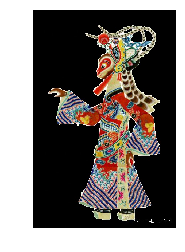

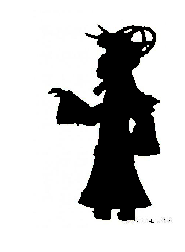

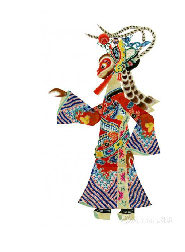

In [41]:
img1 = cv2.imread("demo.jpg")
mask,res = whiteOut(img1)
#final = np.multiply(img1,mask)
#imshow(cv2.bitwise_and(img1,mask))
img2= cv2.bitwise_and(img1,res)
imshow(img2)
res2 = np.abs(255-res)
img3 = cv2.bitwise_and(img1,res2)
imshow(img3)
img4 = np.add(img2,img3)
imshow(img4)

In [57]:
def OverLay(background,image,center,theta,scale):
    #first let's recize the image
    h,w,d = image.shape
    h = int(np.floor(h*scale))
    w = int(np.floor(w*scale))   
    resized  = cv2.resize(image, (w,h))
    
    #rows,cols,d = resized.shape
    #M = cv2.getRotationMatrix2D((np.floor(cols/2),np.floor(rows/2)),theta,1)
    
    #this line needs to be changed for better performance
    #diag = int(np.floor(np.sqrt(rows*rows+cols*cols)))
    #diag = int(np.maximum(rows,cols))
    #dst = cv2.warpAffine(resized,M,(diag,diag),borderValue = (255,255,255))
    
    diag, dst = rotate_bound(resized, theta)
    #diag = int(np.floor(np.sqrt(nW*nW+nH*nH)))
       
    #h,w,d = dst.shape
    mask,res = whiteOut(dst)
    imshow(res)
    
    x_center = center[0]
    y_center = center[1]
    
    result = background.copy()
    cols,rows,d = result.shape
    
    tx = np.floor(x_center - diag/2)
    #xcenter
    ty = np.floor(y_center - diag/2)
    #ycenter
    
    
    Ry0 = int(ty)
    Ry1 = int(ty+diag)
    #Ry1 = int(ty+nH)
    Rx0 = int(tx)
    Rx1 = int(tx+diag)
    #Rx1 = int(tx+nW)
    Fy0 = int(0)
    Fy1 = int(0+diag)
    #Fy1 = int(0+nH)
    Fx0 = int(0)
    Fx1 = int(0+diag)
    #Fx1 = int(0+nW)
    
    
    if tx < 0 or ty < 0 or int(tx + diag) > rows or int(ty+diag) > cols:
        if tx < 0:
            Rx0 = 0
            Rx1 = int(diag-abs(tx))
            Fx0 = int(abs(tx))
        if ty < 0:
            Ry0 = 0
            Ry1 = int(diag-abs(ty))
            Fy0 = int(abs(ty))
        if int(tx + diag) > rows:
            Rx0 = rows - (diag - (int(tx + diag)-rows)) 
            Rx1 = rows
            Fx1 = int(0+diag-(int(tx+diag)-rows)) 
        if int(ty + diag) > cols:
            Ry0 = cols - (diag - (int(ty + diag)-cols)) 
            Ry1 = cols
            Fy1  = int(0+diag-(int(ty+diag)-cols))
    
    '''
    if tx < 0 or ty < 0 or int(tx + diag) > rows or int(ty+diag) > cols:
        if tx < 0:
            Rx0 = 0
            Rx1 = int(diag-abs(tx))
            Fx0 = int(abs(tx))
        if ty < 0:
            Ry0 = 0
            Ry1 = int(diag-abs(ty))
            Fy0 = int(abs(ty))
        if int(tx + diag) > rows:
            Rx0 = rows - (diag - (int(tx + diag)-rows)) 
            Rx1 = rows
            Fx1 = int(0+diag-(int(tx+diag)-rows)) 
        if int(ty + diag) > cols:
            Ry0 = cols - (diag - (int(ty + diag)-cols)) 
            Ry1 = cols
            Fy1  = int(0+diag-(int(ty+diag)-cols))
    '''
            
    newImg = result[Ry0:Ry1,Rx0:Rx1,:]
    dst = dst[Fy0:Fy1,Fx0:Fx1,:]
    res = res[Fy0:Fy1,Fx0:Fx1,:]
    imshow(newImg)
    imshow(dst)
    res2 = np.abs(255-res)
    img2 = cv2.bitwise_and(dst,res)
    img3 = cv2.bitwise_and(newImg,res2)
    final = np.add(img2,img3)
    result[Ry0:Ry1,Rx0:Rx1] = final
    
    return result

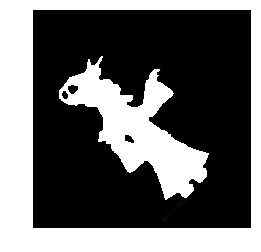

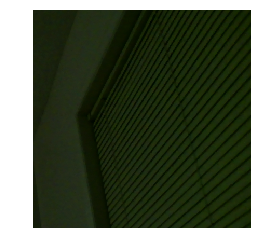

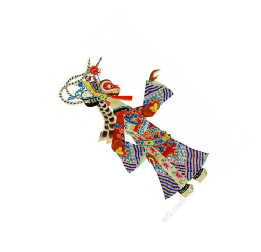

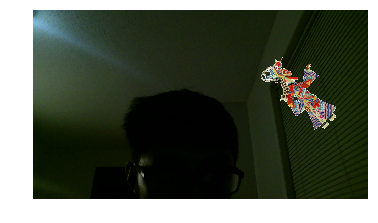

In [60]:
background = cv2.imread("bk.png")
img1 = cv2.imread("demo.jpg")
#resized = cv2.resize(background, (1280, 720))
#resized2 = overLay(background,background,background,background,0.5)
img1 = cv2.flip(img1,1)
result = OverLay(background,img1,[1030,300],45,0.6)
imshow(result)

In [49]:
def newOverLay(background,image,center,theta,scale):
    #first let's recize the image
    h,w,d = image.shape
    h = int(np.floor(h*scale))
    w = int(np.floor(w*scale))   
    resized  = cv2.resize(image, (w,h))
    
    rows,cols,d = resized.shape
    M = cv2.getRotationMatrix2D((np.floor(cols/2),np.floor(rows/2)),theta,1)
    
    #this line needs to be changed for better performance
    diag = int(np.floor(np.sqrt(rows*rows+cols*cols)))
    dst = cv2.warpAffine(resized,M,(diag,diag),borderValue = (255,255,255))
    
    #h,w,d = dst.shape
    mask,res = whiteOut(dst)
    imshow(res)
    
    x_center = center[0]
    y_center = center[1]
    
    tx = np.floor(x_center - diag/2)
    ty = np.floor(y_center - diag/2)
    
    result = background.copy()

    newImg = result[int(ty):int(ty+diag),int(tx):int(tx+diag),:]
    #imshow(newImg)
    res2 = np.abs(255-res)
    img2 = cv2.bitwise_and(dst,res)
    #imshow(img2)
    #print(diag)
    #print(newImg.shape)
    #print(res2.shape)
    img3 = cv2.bitwise_and(newImg,res2)
    final = np.add(img2,img3)
    result[int(ty):int(ty+diag),int(tx):int(tx+diag)] = final
    
    return result

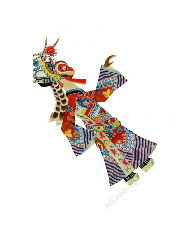

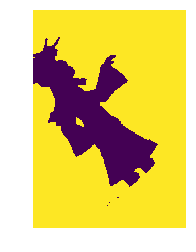

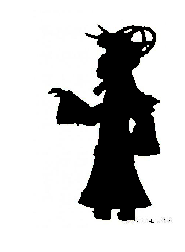

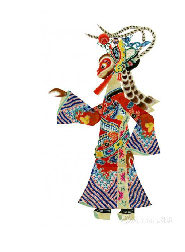

(700, 492, 3)
(600, 392, 3)
[255 255 255]


In [37]:
img = img1.copy()
rows,cols,d = img.shape

M = cv2.getRotationMatrix2D((cols/2,rows/2),40,1)
dst = cv2.warpAffine(img,M,(cols+100,rows+100),borderValue = (255,255,255))
#cv2.warpPerspective(dst, M, (cols+100,rows+100), cv2.INTER_LINEAR, cv2.BORDER_CONSTANT, 255,255,255)
imshow(dst)
newMask,newRes = whiteOut(dst)
imshow(newMask)
img2= cv2.bitwise_and(dst,newRes)
#imshow(img2)
newRes2 = np.abs(255-newRes)
#img3 = cv2.bitwise_and(dst,newRes2)
imshow(img3)
#img4 = np.add(img2,img3)
imshow(img4)
print(dst.shape)
print(img.shape)
print(dst[1][1])

In [8]:
cam = cv2.VideoCapture(0)
img1 = cv2.imread("demo.jpg")
#img3 = cv2.imread("demo0.png")
h,w,d = img1.shape
k = 1
while k==1:
    ret, img2=cam.read()
    print(img2.shape)
    keypressed = cv2.waitKey(5)
    if keypressed == 27:
        break
    cv2.imwrite("bk.png",img2)
    cv2.imshow('mask',img2)
    k = k-1
    
cam.release()
cv2.destroyAllWindows() 

(720, 1280, 3)


In [10]:
np.cos(45*np.pi/180)

0.70710678118654757